In [195]:
# RNN on sine wave, using bp on weight matrix, enforce Dale's law
import numpy as np
import sys
sys.path.append("..")
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import seaborn as sns

## Loading Trained Weights

In [196]:
with open('../weights/SIN2_wt_16_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [197]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight'])

In [198]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

# test oja
# weight_sums = np.array(weight_history['weight_sums'])
# gain_changes = np.array(weight_history['gain_changes'])

In [199]:
weight_matrix

array([[ 1.76317751,  0.73470753,  0.66540623,  1.11159623,  0.98032796,
         2.43906903,  1.89011478,  0.908113  , -0.25353473, -0.18282184,
        -1.44373631, -1.93674505, -0.24170838, -0.23316744, -0.99290395,
        -1.08508062],
       [ 0.46419659,  1.12842977,  0.33024105,  0.67019254,  1.37828898,
         1.43566322,  1.23619521,  0.83903974, -0.75363088, -0.5294441 ,
        -0.05694864, -0.66337812, -0.10235408, -0.21025679, -0.37981668,
        -0.36130059],
       [ 0.94101441,  1.06254768,  0.92014015,  0.0707915 ,  1.27014339,
         0.44964942,  1.84460342,  0.92559248, -0.05076559, -0.7991513 ,
        -0.7090804 , -1.48304021,  0.06888398, -0.36515394,  0.07556763,
        -2.08058381],
       [ 0.19377753,  0.62345016,  0.38294691,  0.34315979,  0.83169103,
         0.78737038,  0.41735947,  0.9238345 , -1.05889988, -1.26878703,
        -0.54905677, -1.0564388 , -0.70840883, -1.13170695, -0.27616686,
        -0.27219081],
       [ 0.        ,  0.        ,  0

In [200]:
np.max(weight_matrix)

2.957399606704712

<Axes: >

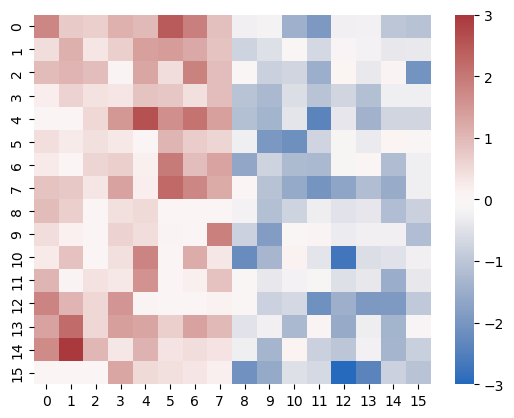

In [201]:
sns.heatmap(weight_matrix, vmax=3, vmin=-3, cmap='vlag')

In [202]:
excite_weights = weight_matrix * (weight_matrix > 0)
# sns.heatmap(excite_weights, vmax=1, vmin=-1, cmap='vlag')

In [203]:
np.sum(excite_weights)

100.1438912008889

In [204]:
# estimate oja's alpha
1 / np.linalg.norm(excite_weights, None)**2

0.007578883746273819

## Defining Network

In [205]:
time_constant = 100 #ms
timestep = 10 #ms
ndata = 400
time = ndata * timestep #ms
num_inputs = 1
num_nodes = 16
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep, 
                # output_nonlinearity=nn.Sigmoid()
                )

100%|██████████| 400/400 [00:00<00:00, 22322.60it/s]


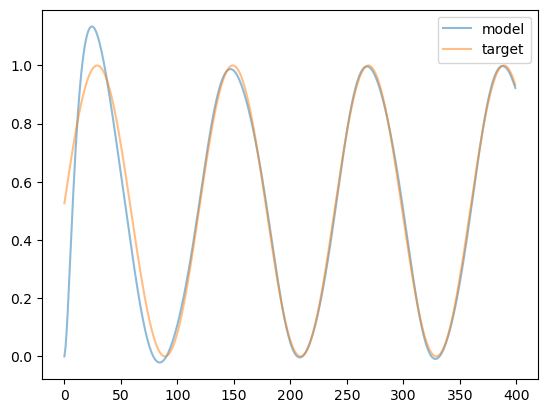

In [206]:
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
# inputs = 0.5 + np.sin(time_points/60*np.pi)/4
# targets = 0.5 + np.sin((time_points+1)/60*np.pi)/4
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

outputs, activations = network.simulate(time, torch.tensor(inputs).float())
fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
# plt.plot(time_points, inputs)
plt.plot(time_points, targets, alpha=0.5, label='target')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_train.png")

100%|██████████| 300/300 [00:00<00:00, 25104.57it/s]


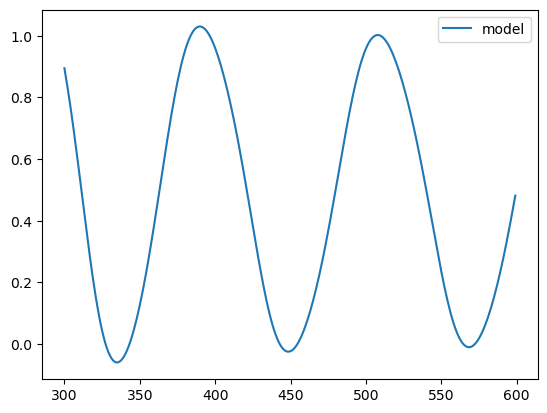

In [207]:
time_pred = 3000

time_points_pred = np.arange(300,600).reshape(-1, 1)
inputs_pred = (1 + np.sin(time_points_pred/60*np.pi))/2

outputs_pred, activations_pred = network.simulate(time_pred, torch.tensor(inputs_pred).float())
fig, ax = plt.subplots()
plt.plot(time_points_pred, outputs_pred.detach().numpy(), label='model')
# plt.ylim([0,1])
plt.legend()
# plt.savefig("fig/sin_oja_pred.png")

Text(0, 0.5, 'loss')

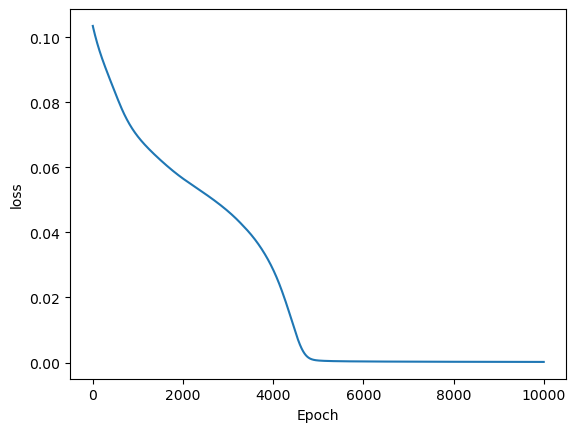

In [208]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
# plt.ylim([0,0.01])
# plt.savefig("fig/sin_oja_loss.png")